# Sentiment Analysis

Essentially, sentiment analysis or sentiment classification fall into the broad category of text classification tasks where you are supplied with a phrase, or a list of phrases and your classifier is supposed to tell if the sentiment behind that is positive, negative or neutral. Sometimes, the third attribute is not taken to keep it a binary classification problem. In recent tasks, sentiments like "somewhat positive" and "somewhat negative" are also being considered.

~ From: https://www.datacamp.com/tutorial/simplifying-sentiment-analysis-python

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import nltk
import random
import string
lemmatize=nltk.WordNetLemmatizer()
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

## Get Data

In [23]:
headers = ["tweetId", "entity", "sentiment", "content"]
data = pd.read_csv('twitter_training.csv', names = headers)
data.head()

,tweetId,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Cleaning the data

### Remove nan values

In [24]:
len(data.index)

74682

In [25]:
data.isnull().sum()

tweetId        0
entity         0
sentiment      0
content      686
dtype: int64

Drop the nan valued content

In [26]:
new_data = data.dropna(axis = 0, how ='any')

In [27]:
new_data.isnull().sum()

tweetId      0
entity       0
sentiment    0
content      0
dtype: int64

In [28]:
len(new_data.index)

73996

### Get rid of duplicate

In [29]:
new_data.duplicated().sum()

2340

In [30]:
new_data = new_data.drop_duplicates()

In [31]:
len(new_data.index)

71656

## Exploratory Data Analysis 

In [32]:
new_data['sentiment'].value_counts()

Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

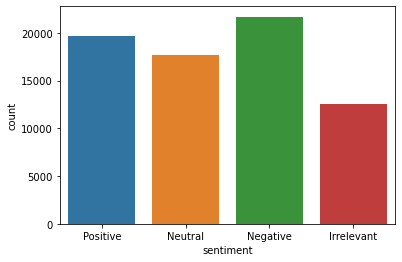

In [16]:
sns.countplot(x=new_data['sentiment'])

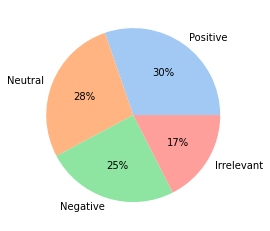

In [33]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(new_data['sentiment'].value_counts(), labels = new_data['sentiment'].unique(), colors = colors, autopct='%.0f%%')
plt.show()

In [34]:
new_data.head()

,tweetId,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


<AxesSubplot:xlabel='entity'>

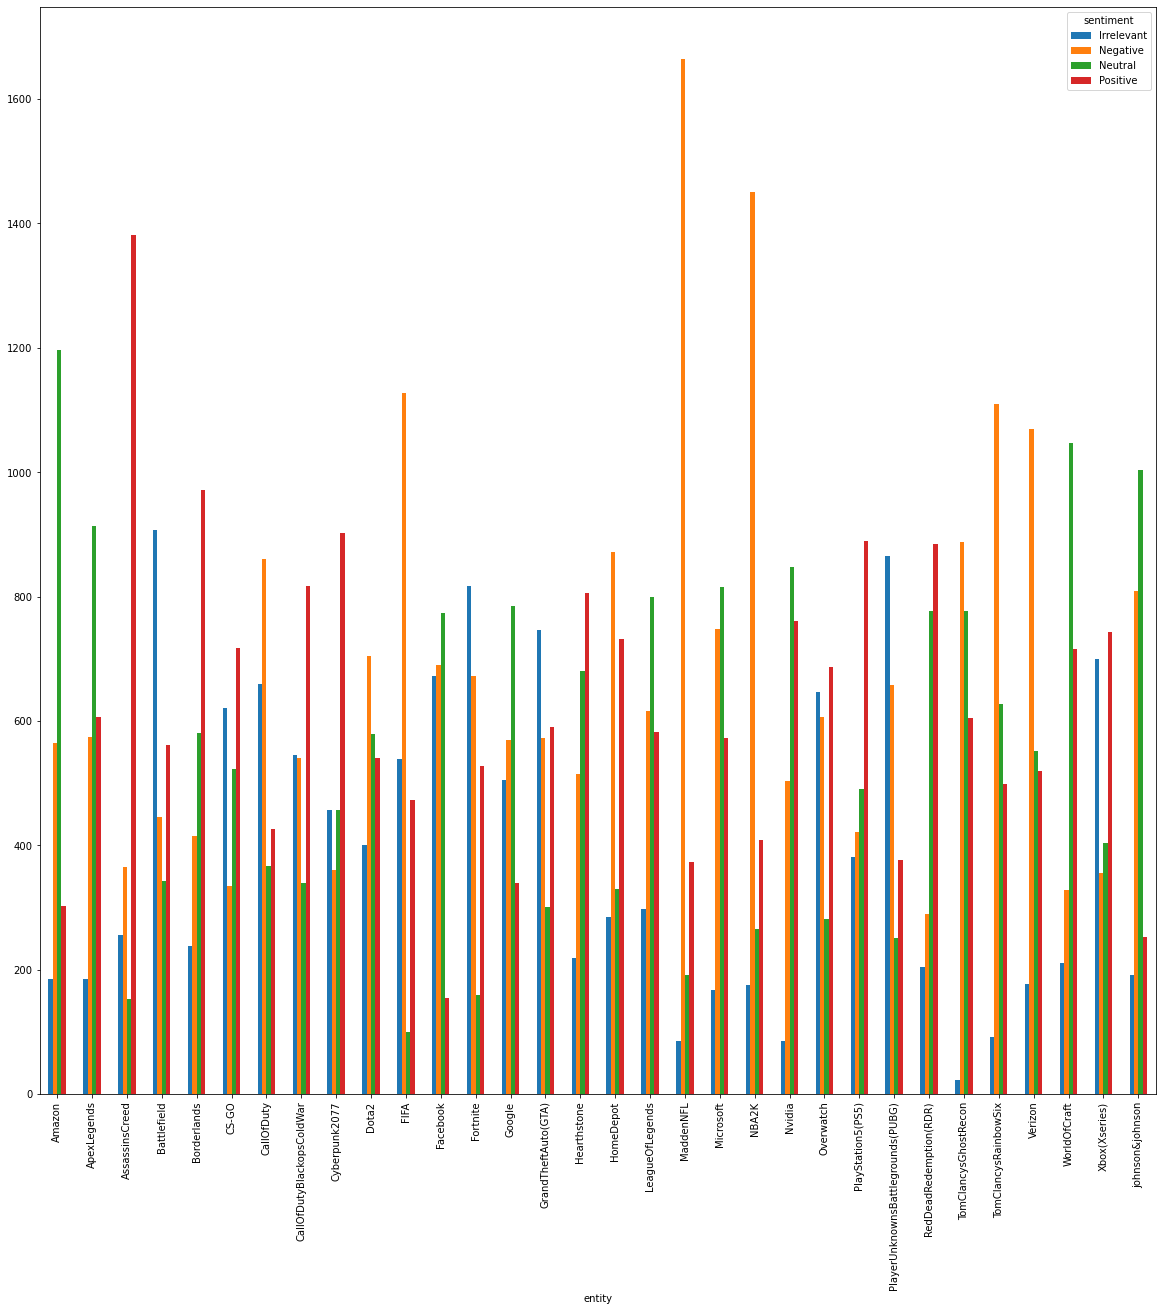

In [35]:
Twitter_sentiment = new_data.groupby(['entity', 'sentiment']).sentiment.count().unstack()
Twitter_sentiment.plot(kind='bar',figsize=(20,20))

## Pre-processing function

Create a function that deletes white space, removes punctuation and stopwords and lemmatize the words

In [36]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Lemmatize the words
    4. Returns a list of the cleaned text
    """
    # Remove xa0 space
    mess.replace(u'\xa0', u' ')
    mess.replace(u'@', u' ')
    
    #Remove white space
    mess.strip()
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # Lemmatize the words
    nopunc = [lemmatize.lemmatize(word) for word in nopunc.split()]
    # Join the characters again to form the string.
    nopunc = ' '.join(nopunc)
    
    # Now just remove any stopwords
    return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]

### Vectorizing the data

Bag of word model

In [37]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(new_data['content'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

40950


In [38]:
content_bow = bow_transformer.transform(new_data['content'])

In [39]:
print('Shape of Sparse Matrix: ', content_bow.shape)
print('Amount of Non-Zero occurences: ', content_bow.nnz)

Shape of Sparse Matrix:  (71656, 40950)
Amount of Non-Zero occurences:  786386


TF-IDF

In [40]:
tfidf_transformer = TfidfTransformer().fit(content_bow)

In [41]:
text_tfidf = tfidf_transformer.transform(content_bow)
print(text_tfidf.shape)

(71656, 40950)


Pipeline using the bow, tf-idf and the Naive Bayes classifier

In [42]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
pipeline.fit(new_data['content'],new_data['sentiment'])

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001ECC2C8AC10>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [43]:
data_test = pd.read_csv('twitter_validation.csv', names = headers)
data_test.head()

,tweetId,entity,sentiment,content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [44]:
predictions = pipeline.predict(data_test['content'])

In [45]:
print(classification_report(predictions,data_test['sentiment']))

              precision    recall  f1-score   support

  Irrelevant       0.63      0.98      0.77       110
    Negative       0.94      0.69      0.79       364
     Neutral       0.68      0.95      0.79       204
    Positive       0.91      0.78      0.84       322

    accuracy                           0.80      1000
   macro avg       0.79      0.85      0.80      1000
weighted avg       0.84      0.80      0.80      1000

